In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import json
import clustering
from clustering.what_if_model import WhatIfModel
from clustering.pqp_input_parser import PQPInputParser
from clustering.util import create_model
import autoreload
import clustering.evaluation

%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)

In [2]:
BASE_PATH_TPCH = "~/Dokumente/repos/example_plugin/stats/final/tpch/sf1-2d/"
TPCH_ORDERKEY = f"{BASE_PATH_TPCH}/l_orderkey"
TPCH_SHIPDATE = f"{BASE_PATH_TPCH}/l_shipdate"

In [3]:
m = create_model("lineitem", PQPInputParser("tpch", TPCH_ORDERKEY), 2)

cost_model_output/models/


In [4]:
CLUSTERING_COLUMN = "l_shipdate"
SIDED = True
join_results = clustering.evaluation.evaluate_join_step(m, TPCH_SHIPDATE, [CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100], "ALL", SIDED)


print(f"There are {len(join_results)} joins")
join_results[['QUERY_HASH1', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'TOTAL_ERROR', 'RELATIVE_ERROR']]

## Estimating ColumnBetween scans
## Estimating ColumnVsValue scans

## Estimating REFERENCE DATA joins
## Estimating REFERENCE REFERENCE joins

## Estimating AggregateHash aggregates
adding column INPUT_COLUMN_SORTED_Ascending
adding column SELECTIVITY_LEFT

There are 20 joins with estimated negative run time. This is bad.
           QUERY_HASH  \
1    af04794535660bfb   
6    550d82dfc9e49105   
20   ca18c361736e9938   
24   bc9c5b09f7327ee    
27   581025346a1e14fe   
37   32c23f6f991a064d   
48   efe8810009ceeca4   
63   65e8223a5ee91fb8   
77   7c90cd3a1b165fad   
100  e16ba5ded0a91c94   
103  3c13b8ba3d206f05   
143  cede475d1331e7a4   
211  8dc3fd52eb6d3c3d   
310  f6311ed25cf11ce6   
318  ab8e3343baeab48e   
338  58d150518c8f1926   
375  6cb6d54beeff1622   
519  73b23b8a1b9c71cd   
569  e7bb22c68d9903fa   
589  f048d2943c79146a   

                                                         DESCRIPTION  \
1    JoinHash (Inner Join where l_partkey = p_partkey) Radix bits: 0   
6   

383 joins with lineitem as probe or build side
There are 383 joins


,QUERY_HASH1,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR
0,129f61e2f3ecf0ef,JoinHash (Inner Join where l_suppkey = s_suppkey) Radix bits: 0,132148,425243,95061,-330182,2.235451e-01
1,140261541ac6b6ba,JoinHash (Semi Join where l_partkey = ps_partkey) Radix bits: 0,40665114,27595181,7274157,-20321024,2.636024e-01
2,140261541ac6b6ba,JoinHash (Semi Join where l_suppkey = ps_suppkey) Radix bits: 0,9881918,13327350,2684312,-10643038,2.014138e-01
3,140261541ac6b6ba,JoinHash (Semi Join where ps_suppkey = l_suppkey AND ps_availqty > 0.5 * SUM(l_quantity) AND ps_partkey = l_partkey) Radix bits: 0,4368434,4435697,3160661,-1275036,7.125512e-01
4,19ae7b7a1d3226b,JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 0,59441541,77669417,109638646,31969229,1.411606e+00
5,19ae7b7a1d3226b,JoinHash (Semi Join where o_orderkey = l_orderkey) Radix bits: 1,28849095,30834700,22193912,-8640788,7.197706e-01
6,20e42e320de74706,JoinHash (Inner Join where l_orderkey = o_orderkey) Radix bits: 0,13652193,16580275,14038580,-2541695,8.467037e-01
7,20e42e320de74706,JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 1,141640928,140381682,109943803,-30437879,7.831777e-01
8,21810eadacd14054,JoinHash (Inner Join where l_suppkey = s_suppkey) Radix bits: 0,45790745,43639824,81475856,37836032,1.867007e+00
9,21810eadacd14054,JoinHash (Inner Join where o_orderkey = l_orderkey) Radix bits: 2,106432166,124521666,128899315,4377649,1.035156e+00


In [ ]:
join_results['e'] = join_results['TOTAL_ERROR'] ** 2
join_results.sort_values(['e'], ascending=False)[["QUERY_HASH1", "DESCRIPTION1", "RUNTIME_BASE_MS", "RUNTIME_ESTIMATE_MS", "RUNTIME_CLUSTERED_MS", "RELATIVE_ERROR", "TOTAL_ERROR_MS"]]
#join_results.sort_values(['e'], ascending=False)[['DESCRIPTION1', 'TOTAL_ERROR']]

In [ ]:
old_join_results = None
#old_join_results = join_results

In [ ]:
clustering.evaluation.print_aggregated_metrics(join_results, m.query_frequencies)
fig = clustering.evaluation.plot_join_errors(join_results, old_join_results, m.query_frequencies)
#old_join_results = join_results
fig
print(f"unclustered join run time is {'{:,}'.format(np.int64(join_results['RUNTIME_BASE'].sum() / 1e6))} ms")

In [ ]:
CLUSTERING_COLUMN = "l_shipdate"
scan_results = clustering.evaluation.evaluate_scans(m, TPCH_SHIPDATE, [CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100])
print(f"There are {len(scan_results)} scans on {m.table_name}")

scan_results[['QUERY_HASH', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'TOTAL_ERROR', 'RELATIVE_ERROR']].sort_values(['TOTAL_ERROR'], ascending=False)

In [ ]:
old_scan_results = None

In [ ]:
clustering.evaluation.print_aggregated_metrics(scan_results, m.query_frequencies)
fig = clustering.evaluation.plot_scan_errors(scan_results, old_scan_results, m.query_frequencies)
#old_scan_results = scan_results
fig
print(f"unclustered scan run time (on {m.table_name}) is {'{:,}'.format(np.int64(scan_results['RUNTIME_BASE'].sum() / 1e6))} ms")

In [ ]:
scan_results['e'] = scan_results['TOTAL_ERROR'] ** 2
scan_results['IMPLEMENTATION'] = scan_results.apply(lambda x: x['DESCRIPTION1'].split("Impl: ")[1].split()[0], axis=1)
scan_results['DESC'] = scan_results.apply(lambda x: " ".join(x['DESCRIPTION1'].split(" ")[3:]), axis=1)
scan_results.sort_values(['e'], ascending=False)[["QUERY_HASH", "DESC", "COLUMN_NAME", "RUNTIME_BASE", "RUNTIME_ESTIMATE", "RUNTIME_CLUSTERED", "TOTAL_ERROR", "RELATIVE_ERROR"]]
#scan_results['DESCRIPTION1'].apply(lambda x: "Like" in x).any()

In [ ]:
joindbg = pd.read_csv(TPCH_SHIPDATE + "/joins.csv", sep='|')
joindbg.dropna(inplace=True)
joindbg['BUILD_COLUMN'] = joindbg.apply(lambda x: x[f"{x['BUILD_SIDE']}_COLUMN_NAME"], axis=1)
joindbg['PROBE_COLUMN'] = joindbg.apply(lambda x: x[f"{x['PROBE_SIDE']}_COLUMN_NAME"], axis=1)
viewcols = ['QUERY_HASH', 'IS_FLIPPED', 'PROBE_SORTED', 'BUILD_SORTED', 'PROBE_COLUMN', 'BUILD_COLUMN', 'DESCRIPTION']
joindbg[joindbg['QUERY_HASH'] == '3534234c34669919'][viewcols]

In [ ]:
p = PQPInputParser("tpch", TPCH_ORDERKEY)
p.load_statistics()
p.get_aggregates()

In [ ]:
scan_results[scan_results['RUNTIME_ESTIMATE'] == 1]

In [14]:
CLUSTERING_COLUMN = "l_shipdate"
aggregate_results = clustering.evaluation.evaluate_aggregates(m, TPCH_SHIPDATE, [CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100])
print(f"There are {len(aggregate_results)} aggregates")
aggregate_results['e'] = aggregate_results['TOTAL_ERROR'] ** 2
aggregate_results.sort_values(['e'], ascending=False)[['QUERY_HASH', 'DESCRIPTION1', 'RUNTIME_BASE_MS', 'RUNTIME_ESTIMATE_MS', 'RUNTIME_CLUSTERED_MS', 'TOTAL_ERROR_MS', 'RELATIVE_ERROR']]

## Estimating ColumnBetween scans
## Estimating ColumnVsValue scans

## Estimating REFERENCE DATA joins
## Estimating REFERENCE REFERENCE joins

## Estimating AggregateHash aggregates
adding column INPUT_COLUMN_SORTED_Ascending
adding column SELECTIVITY_LEFT

There are 235 aggregates


,QUERY_HASH,DESCRIPTION1,RUNTIME_BASE_MS,RUNTIME_ESTIMATE_MS,RUNTIME_CLUSTERED_MS,TOTAL_ERROR_MS,RELATIVE_ERROR
162,b9d744d428f1b8a1,AggregateHash GroupBy ColumnIDs: 0 Aggregates: SUM(l_quantity),622,"1,385",895,-490,0.646415
148,a795bcf5e93582f1,AggregateHash GroupBy ColumnIDs: 0 Aggregates: SUM(l_quantity),640,461,917,455,1.985895
66,5689aad98171d7d2,AggregateHash GroupBy ColumnIDs: 0 Aggregates: SUM(l_quantity),621,461,908,446,1.966369
174,c64dec9688a08c55,AggregateHash GroupBy ColumnIDs: 0 Aggregates: SUM(l_quantity),616,461,889,427,1.924544
141,a44a3d6989b5b76a,AggregateHash GroupBy ColumnIDs: 0 Aggregates: COUNT(o_orderkey),264,79,262,183,3.298665
108,7a589f8ab18426d6,"AggregateHash GroupBy ColumnIDs: 5, 6 Aggregates: SUM(l_quantity), SUM(l_extendedprice), SUM(l_extendedprice * (1 - l_discount)), SUM((l_extendedprice * (1 - l_discount)) * (1 + l_tax)), AVG(l_discount), COUNT(*)","1,465","1,298","1,458",159,1.123073
132,9a1adec8eeee6ec1,"AggregateHash GroupBy ColumnIDs: 5, 6 Aggregates: SUM(l_quantity), SUM(l_extendedprice), SUM(l_extendedprice * (1 - l_discount)), SUM((l_extendedprice * (1 - l_discount)) * (1 + l_tax)), AVG(l_discount), COUNT(*)","1,522","1,289","1,426",137,1.106399
97,6fb3f7e54d76ceed,"AggregateHash GroupBy ColumnIDs: 5, 6 Aggregates: SUM(l_quantity), SUM(l_extendedprice), SUM(l_extendedprice * (1 - l_discount)), SUM((l_extendedprice * (1 - l_discount)) * (1 + l_tax)), AVG(l_discount), COUNT(*)","1,523","1,301","1,434",132,1.101803
77,5aa537e0d658225a,"AggregateHash GroupBy ColumnIDs: 5, 6 Aggregates: SUM(l_quantity), SUM(l_extendedprice), SUM(l_extendedprice * (1 - l_discount)), SUM((l_extendedprice * (1 - l_discount)) * (1 + l_tax)), AVG(l_discount), COUNT(*)","1,575","1,281","1,413",132,1.103223
55,4e4cb5b90ba5de03,"AggregateHash GroupBy ColumnIDs: 5, 6 Aggregates: SUM(l_quantity), SUM(l_extendedprice), SUM(l_extendedprice * (1 - l_discount)), SUM((l_extendedprice * (1 - l_discount)) * (1 + l_tax)), AVG(l_discount), COUNT(*)","1,543","1,281","1,408",127,1.099311


In [15]:
old_aggregate_results = None

There are 235 operators

28% of the operator estimates are over- or underestimated between factor 1 and 1.5
28% of the operator estimates are over- or underestimated between factor 1.5 and 3
42% of the operator estimates are over- or underestimated between factor 3 and 100

Total estimate: 23,508 ms
Total measured: 27,564 ms
MSE: 25,459 ms^2
SMAPE: 89%


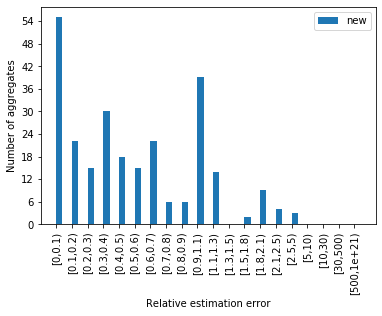

unclustered aggregate run time is 21,267 ms


In [16]:
clustering.evaluation.print_aggregated_metrics(aggregate_results, m.query_frequencies)
fig = clustering.evaluation.plot_aggregate_errors(aggregate_results, old_aggregate_results, m.query_frequencies)
#old_aggregate_results = aggregate_results
fig
print(f"unclustered aggregate run time is {'{:,}'.format(np.int64(aggregate_results['RUNTIME_BASE'].sum() / 1e6))} ms")